In [40]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [41]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [42]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [43]:
df = df.resample('d').mean()

In [44]:
for field in cnames:
    print(field, df[field].isna().sum())


year 0
month 0
day 0
DEWP 0
TEMP 0
PRES 0
Iws 0
day_of_week 0
weekend 0
cbwd_NE 0
cbwd_NW 0
cbwd_SE 0
cbwd_cv 0
PM2.5 0


In [45]:
# df.corr(method='pearson')

In [46]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [47]:
df = df.iloc[:-2,:]

In [48]:
#Change the column name here to change the environment factor to be taken into the model
df = df[['year','month','day','TEMP','day_of_week','weekend','PM2.5']]

In [49]:
df.head()

,year,month,day,TEMP,day_of_week,weekend,PM2.5
date,,,,,,,
2010-01-02,2010.0,1.0,2.0,-5.125000,5.0,1.0,145.958333
2010-01-03,2010.0,1.0,3.0,-8.541667,6.0,1.0,78.833333
2010-01-04,2010.0,1.0,4.0,-11.500000,0.0,0.0,31.333333
2010-01-05,2010.0,1.0,5.0,-14.458333,1.0,0.0,42.458333
2010-01-06,2010.0,1.0,6.0,-12.541667,2.0,0.0,56.416667


In [50]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

cnames = df.columns
for field in cnames:
    df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())

# choose a number of time steps
n_steps_in, n_steps_out = 15, 4

X, y = split_sequences(df.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]


In [51]:
df.head()

,year,month,day,TEMP,day_of_week,weekend,PM2.5
date,,,,,,,
2010-01-02,0.0,0.0,0.033333,0.197183,0.833333,1.0,0.269502
2010-01-03,0.0,0.0,0.066667,0.125000,1.000000,1.0,0.142996
2010-01-04,0.0,0.0,0.100000,0.062500,0.000000,0.0,0.053476
2010-01-05,0.0,0.0,0.133333,0.000000,0.166667,0.0,0.074443
2010-01-06,0.0,0.0,0.166667,0.040493,0.333333,0.0,0.100749


In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
# from keras.layers import GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Dropout

In [53]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))

# model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='RMSProp', loss='mse')


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X, y, callbacks=[monitor],validation_split=0.1, verbose=1, epochs=2000)

#from sklearn.externals import joblib 
#path = "/content/drive/My Drive/"
#name_file = "model82AEMaxScaled.pkl"  
# Save the model as a pickle in a file 
#joblib.dump(model, path+name_file)

Epoch 1/2000
51/51 [==============================] - 1s 29ms/step - loss: 0.0237 - val_loss: 0.0194
Epoch 2/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0207 - val_loss: 0.0193
Epoch 3/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0199 - val_loss: 0.0208
Epoch 4/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0196 - val_loss: 0.0192
Epoch 5/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 6/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 7/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0192 - val_loss: 0.0198
Epoch 8/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.0191
Epoch 9/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 10/2000
51/51 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.019

In [55]:
x_input = array(X_test)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=2)
print((yhat[0]*std_dev)+mean)
print((y_test*std_dev)+mean)

1/1 - 0s
[137.48022 127.687   189.0612  254.18164]
[313.39075108 441.55703085 364.20454409 292.31590605]


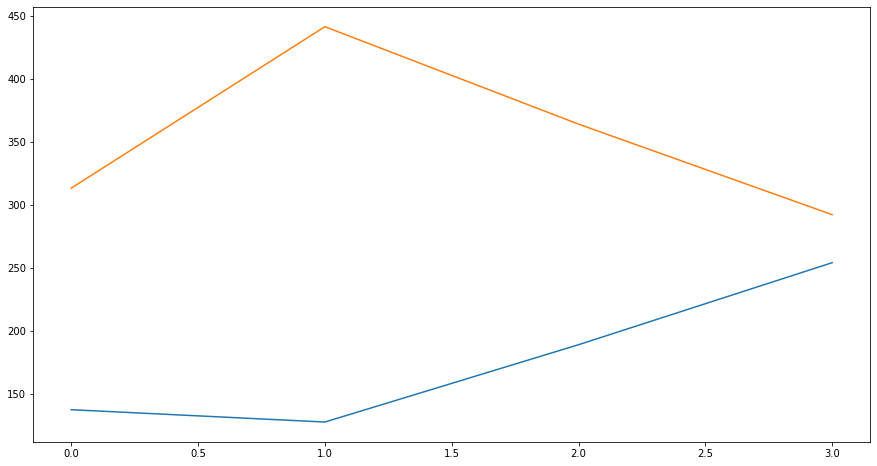

In [56]:
#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

# fig, ax = plt.subplots()
plt.plot((yhat[0]*std_dev)+mean)
plt.plot((y_test*std_dev)+mean)
plt.show()

In [57]:
x_ann = []

for inp_val in X:
  x_input_ann = inp_val.reshape((1, n_steps_in, n_features))
  y_newpred = model.predict(x_input_ann, verbose = 1)
  x_ann.append(y_newpred)


1/1 [==============================] - 0s 2ms/step


In [58]:
x_ann = array(x_ann)
x_ann_new = x_ann[:, 0, :]
x_ann_new.shape
x_ann_new = x_ann_new.reshape(x_ann_new.shape[0], x_ann_new.shape[1], -1)
y_new = y.reshape(y.shape[0], y.shape[1], -1)

In [59]:
from numpy import array
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import GRU


In [60]:
model_auto = Sequential()
model_auto.add(Bidirectional(GRU(100, activation='relu', input_shape=(x_ann_new.shape[1], x_ann_new.shape[2]),return_sequences=True)))
model_auto.add(Bidirectional(GRU(50, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(10, activation='relu')))
model_auto.add(RepeatVector(x_ann_new.shape[1]))
model_auto.add(Bidirectional(GRU(100, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(50, activation='relu', return_sequences=True)))
model_auto.add(Bidirectional(GRU(10, activation='relu', return_sequences=True)))
model_auto.add(TimeDistributed(Dense(1)))
model_auto.compile(optimizer='adam', loss='mse')


In [61]:
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model_auto.fit(x_ann_new, y_new, callbacks=[monitor], validation_split = 0.1, verbose=1, epochs=2000)
#model_auto.save("autoEncoderModel.h5")


Epoch 1/2000
51/51 [==============================] - 3s 64ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 2/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0128 - val_loss: 0.0286
Epoch 3/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0122 - val_loss: 0.0320
Epoch 4/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0120 - val_loss: 0.0308
Epoch 5/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0116 - val_loss: 0.0314
Epoch 6/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0099 - val_loss: 0.0342
Epoch 7/2000
51/51 [==============================] - 2s 32ms/step - loss: 0.0095 - val_loss: 0.0338
Epoch 8/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0093 - val_loss: 0.0375
Epoch 9/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0093 - val_loss: 0.0342
Epoch 10/2000
51/51 [==============================] - 2s 31ms/step - loss: 0.0092 - val_lo

In [62]:
y_test.shape
y_test_new = y_test.reshape(y_test.shape[0], -1)


In [63]:
y_test_new.shape
y_test_new = y_test_new.T
y_test_new = y_test_new.reshape(y_test_new.shape[0], y_test_new.shape[1], -1)
print(y_test_new.shape)


(1, 4, 1)


In [64]:
x_ann_new_input = array(y_test_new)
yhat_new = model_auto.predict(x_ann_new_input, verbose=1)


1/1 [==============================] - 0s 2ms/step


In [65]:
print(yhat_new.shape)
print(y_test_new.shape)


(1, 4, 1)
(1, 4, 1)


In [66]:
y_test_new_actual = (y_test_new[0]*std_dev)+mean
yhat_predicted = (yhat_new[0]*std_dev)+mean


[[335.65698]
 [390.27478]
 [383.68912]
 [310.1282 ]]
[[313.39075108]
 [441.55703085]
 [364.20454409]
 [292.31590605]]


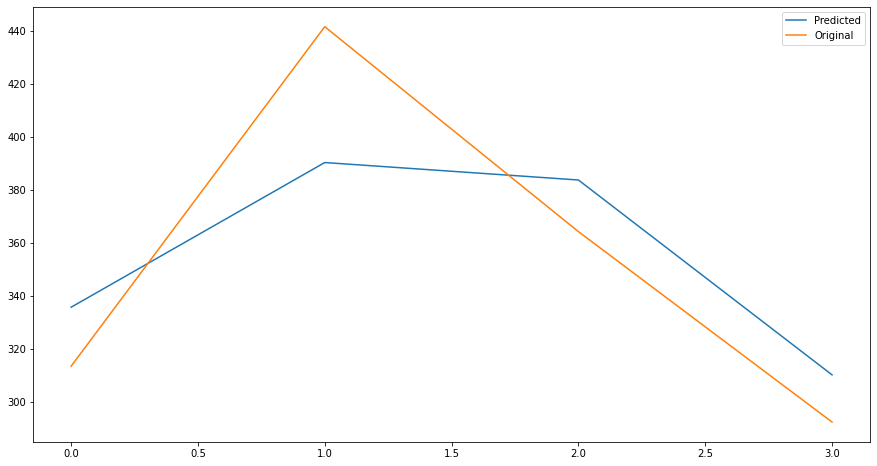

In [67]:
print(yhat_predicted)
print(y_test_new_actual)
plt.plot((yhat_predicted),label = 'Predicted')
plt.plot((y_test_new_actual), label = 'Original')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test_new_actual, yhat_predicted))
print(rms_new)

mse_new = mean_squared_error(y_test_new_actual, yhat_predicted)
print(mse_new)

mae_new = mean_absolute_error(y_test_new_actual, yhat_predicted)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test_new_actual, yhat_predicted)
print(mape_new)


30.913511814910333
955.6452127306007
27.711338388098298
7.5405772198306105
